## Preamble

Пояснения к коду написаны в формате докстрингов, комментариев и Markdown.

Я нормально не тестировал функции, поэтому нижеследующее -- это скорее текст по проделанному резерчу. Хотя код писался из практических соображений.

В каком-то месте я мог по невнимательности забыть умножить флопсы на число слоев или перевести параметры в число байт, и скорее всего где-то забыл.

## Imports

In [15]:
%%capture
import sys
import numpy as np
import torch
import os
from typing import Tuple, Optional, Callable

## Specs of Models with Notes

Basic specs (e.g. hidden_dim) were mostly taken from orginal papers. Rarely taken from huggingface implementation (e.g. LLaMA feed_forward_dim).

#### LLaMA
Compared to naive decoder there are no architectual changes of substantial importanse for us, see e.g. https://paperswithcode.com/method/llama.
Activation functions, Rotary Embeddings and Normalizations are computationaly negligible.
Although some of them might introduce slight memory footprint or FLOPs expantion depending on their implementation 
(e.g. SILU and SwiGLU activations, (x2)), it does not change the bigger picture as will be discussed later.
#### LLaMA2
I hope I am not wrong about this, but the only relevant thing seems to be grouped-query attention.
#### Mistral 
Mistral is a bit different. It uses sliding window attention and grouped-query attention, has different hyperparams and some hacks that are not relevant to us at the moment.
#### Mixtral
Mixtral is like Mistral, but with MoE and without a paper. 
Basically, during inference FF layers double for each token (in a parallel manner) and a small routing layer is added in front of FF.
Also 8 FFs need to be kept in VRAM for eash layer instead of 1. 
This results in a significant memory footprint since FFs take the most of Mistral parameters.

In [7]:
format_2_byte_factor = {
    'fp32': 4, 
    'fp16': 2, 
    'int8': 1, 
    'int4': 0.5,
  }

specs = {
  'LLaMA': {
    'params': 6.7e9,
    'dim': 4096, 
    'feed_forward_dim': 11008, 
    'n_heads': 32,
    'n_kv_heads': 32, 
    # in a context of grouped-query attention
    'n_layers': 32,
    'max_tokens': 2048, 
    # Since the model was not trained on longer sequences, exceeding that might lead to poor performance. 
    # That will not be allowed to piss everyone off.
    'sliding_window': np.inf,
  },
  'LLaMA2': {
    'params': 6.7e9,
    'dim': 4096, 
    'feed_forward_dim': 11008, 
    'n_heads': 32,
    'n_kv_heads': 8,
    'n_layers': 32,
    'max_tokens': 4096,
    'sliding_window': np.inf,
  },
  'Mistral': {
    'params': 7.3e9,
    'dim': 4096, 
    'feed_forward_dim': 14336, 
    'n_heads': 32,
    'n_kv_heads': 8,
    'n_layers': 32,
    'max_tokens': 131072, # They say 8k works fine. 131072 is just a context length.
    'sliding_window': 4096,
  },
  'Mixtral': {
    'params': 46.7e9,
    'dim': 4096, 
    'feed_forward_dim': 14336, 
    'n_heads': 32,
    'n_kv_heads': 8,
    'n_layers': 32,
    'max_tokens': 131072, # They say 32k works fine. 131072 is just a context length.
    'sliding_window': 4096,
  } # number of experts is hardcoded to 2
}

## Task 1

In [ ]:
def calc_max_length(gpu_mem: int, model_arch: str, model_format: str, KV_cache_format: str):
  """
  Calculates theoretical max context+output length under the given constraints.
  Assumptions: 
   - only one GPU is used
   - batch size = 1
   - max context length is calculated for the smallest available model version of a corresponding architecture, 
   as it have not been stated explicitly how to handle this aspect. I believe it is not a substantial aspect, 
   although a tedious one.
  
  Args:
    gpu_mem: Available GPU Global Memory in bytes
    model_arch: one of ['LLaMA', 'LLaMA2', 'Mistral', 'Mixtral']
    model_format: one of ['fp32', 'fp16', 'int8', 'int4']
    KV_cache_format: a format of previous key value cache, one of ['fp32', 'fp16', 'int8']

  Returns:
    Max number of context tokens+1 (under the most sensible and favourable setup that meets all the input 
    constraints). Or max context+output length in other words.

  So here is what I think.
  1) We will use cache and never recalculate attention for the same token, based on task formulation.
  2) For memory efficiency purposes context will be treated the same way as generated content -- with multiple 
  forward passes.
  In some cases, it might significantly slow us down (as when model generates only one token), 
  but memory footprint reduction might be worth it, especially with low KV_cache_format.
  See the next task for an alternative approach on context processing.
  3) We will not use CPU offloading since it conceptually undermines our mission.
  """

  # We could binsearch for a right number of tokens, but I will keep it simple, assuming it can't be bigger than 1000k.
  if can_fit_n(1000000, gpu_mem, model_arch, model_format, KV_cache_format):
    print('seems like it can feet anything beyond reasonable, we can\'t handle that')
    return -1
    
  for n in range(1000000):
    if not can_fit_n(n, gpu_mem, model_arch, model_format, KV_cache_format):
      return n
      

def can_fit_n(n: int, gpu_mem: int, model_arch: str, model_format: str, KV_cache_format: str):
  """
  Checks whether calc_max_length(...) >= n. For more see calc_max_length().

  Returns:
    bool: whether n tokens can be processed to generate one
  """

  spec = specs[model_arch]
  
  if n > spec['max_tokens']:
    return False

  # bytes to store kv cache
  kv_cash_mem = 2 * min(spec['sliding_window'], n-1) * format_2_byte_factor[KV_cache_format] * spec['n_kv_heads'] * \
                (spec['dim'] / spec['n_heads']) * spec['n_layers']
  
  # memory to store intermediate activations of FeedForward, as feed_forward_dim >= dim always
  # As always, I suppose that SwiGLU (llama1,2) or SILU (Mistral, Mixtral) activations are implemented in such a way
  # that does not require extra memory in global gpu memory storage. Otherwise FF_mem should be multiplied by 2.
  FF_bottleneck_mem = (spec['feed_forward_dim'] + spec['dim']) * \
                      format_2_byte_factor[model_format] # spec['dim'] for residual connection
  if model_arch == 'Mixtral':
    FF_bottleneck_mem *= 2 # since we use 2 experts; gated layer is small

  # current attention layer extra memory. We probably compute k,v,q for 1 token simultaneously,
  # and then send our query to SM's local memory to compute dot products.
  # Since this query duplication does not affect the global memory, we should not worry.
  # And k,v are just cached. Cache for all layers was addressed in kv_cash_mem.
  # I also add +1 for outputs of Attention since I assume an implementation akin to Flash Attention forward.
  token_atten_mem = (1+3) * spec['dim'] * format_2_byte_factor[model_format] 

  # We are only interested in bottleneck, although it should be quite small anyway;
  # emb_dim and out_dim equal dim.
  activations_bottleneck_mem = max(FF_bottleneck_mem, token_atten_mem)

  # bytes to store the model
  model_mem = spec['params'] * format_2_byte_factor[model_format]

  return gpu_mem >= model_mem + activations_bottleneck_mem + kv_cash_mem

## GPU specs

A quote from NVIDIA, https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf:

"Ampere architecture introduces new support for TF32, enabling AI training to use tensor cores by default with no effort on the user’s part. Non-tensor operations continue to use the FP32 datapath, while TF32 tensor cores read FP32 data and use the same range as FP32 with reduced internal precision..."

I concentrate our attention on TF format, since the vast majority of compute is occupied by matrix (or matrix by vector) multiplication.

For int4 on V100 it seems like NVIDIA (and everybody) literally doesn't know. For H100 as well.

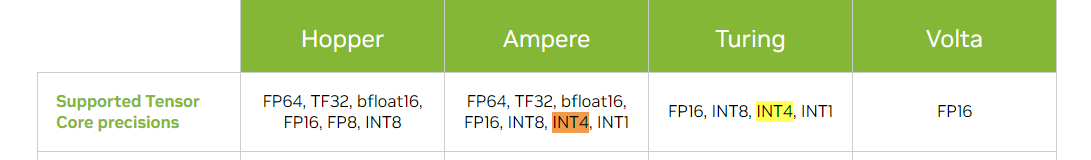

Also there are no Tensor cores for int4 on V100 and H100. So for H100 I will assume that the fastest way would be to
cast it to int8 and use tensor cores. And I will also assume that such a casting is fast. For V100 I will use a bit of information from NVIDIA, 2019:
"INT4 Precision Can Bring an Additional 59% Speedup Compared to INT8". Since there are no Tensor Cores on V100 for int8 either, that seems fair.

In [14]:
gpu_specs = {
  'V100': {
    'HBM': 32e9, # in bytes
    'bandwidth': 0.9e12, # per sec
    'fp32': 125e12, # FLOPS for that data format on tensors. Is specified as "Tensor Performance" in NVIDIA guide.
    'fp16': 130e12, # It's all weird with V100, can't find official info.
    'int8': 62.8e12, # TOPS, less than fp32 since there are no tensor cores for int8
    'int4': 100e12, # see assumption above
  },
  'A100': {
    'HBM': 80e9,
    'bandwidth': 1.935e12,
    'fp32': 156e12, # FLOPS for that data format. It in fact corrresponds to TF32 tensor cores.
    'fp16': 312e12,
    'int8': 624e12, # TOPS
    'int4': 1.248e15,
  },
  'H100': {
    'HBM': 80e9,
    'bandwidth': 3.35e12,
    'fp32': 494e12,
    'fp16': 989e12, 
    'int8': 1.978e15,
    'int4': 1.978e15, # see assuption above
  },
}

## Task 2

In [12]:
def inference_memory(model_arch: str, model_format: str, KV_cache_format: str, in_len: int, out_len: int):
  """
  Calculates inference memory footprint.

  Args:
    model_arch: one of ['LLaMA', 'LLaMA2', 'Mistral', 'Mixtral']
    model_format: one of ['fp32', 'fp16', 'int8', 'int4']
    KV_cache_format: a format of previous key value cache, one of ['fp32', 'fp16', 'int8']
    in_len: max context length
    out_len: max output length

  Returns
    int: required HBM memory in bytes
  
  Since input and output were set apart in the task formulation, 
  I decided that it would be more appropriate to process context tokens in parallel, unlike how we did in the first task.
  I assume Attention through the context tokens is computed the same way as in Flash Attention forward.
  """
  
  spec = specs[model_arch]
  
  assert in_len+out_len <= spec['max_tokens'], 'This model can\'t handle a text that long'

  # bytes to store the model
  model_mem = spec['params'] * format_2_byte_factor[model_format]
  
  # bytes to store kv cache
  # see calc_max_length() for more details
  kv_cash_mem = 2 * min(spec['sliding_window'], in_len+out_len-1) * format_2_byte_factor[KV_cache_format] * \
                spec['n_kv_heads'] * (spec['dim'] / spec['n_heads']) * spec['n_layers']

  # bytes for successive token activations
  # see calc_max_length() for more details
  gen_FF_bottleneck_mem = (spec['feed_forward_dim'] + spec['dim']) * \
                          format_2_byte_factor[model_format] # spec['dim'] for residual connection
  if model_arch == 'Mixtral':
    gen_FF_bottleneck_mem *= 2 
  gen_token_atten_mem = (1+3) * spec['dim'] * format_2_byte_factor[model_format] 
  gen_activations_bottleneck_mem = max(gen_FF_bottleneck_mem, gen_token_atten_mem)

  # bytes for context activations
  # see calc_max_length() for more details
  con_FF_bottleneck_mem = (spec['feed_forward_dim'] + spec['dim']) * format_2_byte_factor[model_format] * in_len
  if model_arch == 'Mixtral':
    con_FF_bottleneck_mem *= 2 
  # I assume that Flash Attention statistics l, m are kept in local memory. 
  # Otherwize we should add 2*in_len*format to the memory footprint, 
  # which is negligible anyway.
  # As usual, objects that arise during intermediate computations are assumed to be kept in local memory, 
  # in a Fused Kernel fashion.
  # See calc_max_length() for more details.
  con_token_atten_mem = (1+3) * spec['dim'] * in_len * format_2_byte_factor[model_format] 
  con_activations_bottleneck_mem = max(con_FF_bottleneck_mem, con_token_atten_mem)

  return model_mem + max(kv_cash_mem + gen_activations_bottleneck_mem, con_activations_bottleneck_mem)

In [16]:
def inference_times(gpu_name: str, model_arch: str, model_format: str, KV_cache_format: str, in_len: int, out_len: int):
  """
  Calculates 
   - context processing time (including HBM transfer),
   - token generation latency when using kv cash and having context of length in_len 
     (a bit weird since we don't use out_len here, but no big deal),
   - approximate ratio between Attention and FF FLOPs
     (as a proxy to Atten and FF operation times: 
     '...времени работы между операциями attention'а (зависит квадратично от входа) и остальными операциями'). 
     The reasons why this proxy seems appropriate to me are the following:
       1) the vast majority of heavy operations of any heavy layer are matrix multiplications, 
          which are performed by the same cores in GPU;
       2) an assumption that we have a full parallelization and 100% GPU loading.
     Note that here HBM memory transfer is not accounted for (as suggested by the task formulation),
     although it might contribute significantly to the whole layer latency.

  Assumptions:
    - 100% GPU utilisation during Atten and FF layers computation.
    - Activation functions, Rotary Embeddings and Normalizations are computationaly negligible -- 
      linear in context length and in hidden dim, 
      while matrix mul are linear in context length and quadratic in hidden dim. 
      Therefore they will not be accounted for.
    - I honestly don't see any info on HBM latency, 
      so I just presuppose that model is big enough and intra-level kernels are fused marvelously. 
      And compute latency using GPU throughput values 
      (as layer_memory/throughput).
      
  Args:
    gpu_name: one of ['V100', 'A100', 'H100']
    args similar to args of inference_memory()

  Returns:
    Context processing time in seconds, 
    gen_latency in seconds for a context of length in_len,
    Atten_FLOPs/FF_FLOPs
  """
  
  spec = specs[model_arch]
  gpu_spec = gpu_specs['gpu_name']

  assert in_len+out_len <= spec['max_tokens'], 'This model can\'t handle a text that long'

  # Due to fancy activations of llama and Mistral we fave factor 3 instead of 2 here.
  # The second factor represents our vision of multiplying matrix by vector in 2 * n*d operations (mul then sum).
  con_FF_FLOPs = 3 * 2 * in_len * spec['feed_forward_dim'] * spec['dim'] * spec['n_layers']
  if model_arch == 'Mixtral':
    con_FF_FLOPs *= 2

  # For details see Appendix C in Flash Attention paper https://arxiv.org/abs/2205.14135
  # I assume real factors (2 * 2) instead of big-O notation. The first 2 stands for mul then sum in matmul.
  # The second factor 2 stands for two mat muls -- QK and PV.
  con_Atten_inner_FLOPs = 2 * 2 * in_len**2 * spec['dim']  * spec['n_layers']
  # approximate number of FLOPs to get q,k,v for all heads
  con_qkv_FLOPs = 2 * 3 * in_len * spec['dim']**2 * spec['n_layers']
  con_Atten_FLOPs = con_Atten_inner_FLOPs + con_qkv_FLOPs

  HBM_model_transfer = spec['params'] * format_2_byte_factor[model_format] / gpu_spec['bandwidth']

  # Now moving to activations transfer:
  con_FF_bottleneck_mem = (spec['feed_forward_dim'] + spec['dim']) * format_2_byte_factor[model_format] * in_len
  if model_arch == 'Mixtral':
    con_FF_bottleneck_mem *= 2 
  # See inference_memory() for comments
  con_token_atten_mem = (1+3) * spec['dim'] * in_len * format_2_byte_factor[model_format] 
  con_activations_bottleneck_mem = max(con_FF_bottleneck_mem, con_token_atten_mem)
  
  # approximately that
  HBM_activations_transfer = (con_FF_bottleneck_mem+con_token_atten_mem) * spec['n_layers'] / gpu_spec['bandwidth']

  # Context processing time. kv cache format conversion time is considered negligible.
  con_proc_time = HBM_model_transfer + (con_Atten_FLOPs+con_FF_FLOPs)/gpu_spec[model_format]

  # Now moving to token generation latency

  # Analogously to context processing
  gen_FF_FLOPs = 3 * 2 * spec['feed_forward_dim'] * spec['dim'] * spec['n_layers']
  if model_arch == 'Mixtral':
    gen_FF_FLOPs *= 2

  # operations shrink in Q along N-dimention
  gen_Atten_inner_FLOPs = 2 * 2 * in_len**1 * spec['dim']  * spec['n_layers']
  gen_qkv_FLOPs = 2 * 3 * spec['dim']**2 * spec['n_layers']

  kv_cash_mem = 2 * min(spec['sliding_window'], in_len+out_len-1) * format_2_byte_factor[KV_cache_format] * \
                spec['n_kv_heads'] * (spec['dim'] / spec['n_heads']) * spec['n_layers']
  HBM_kv_transfer = kv_cash_mem / gpu_spec['bandwidth']

  # Here I assume that token activations are kept in local memory (cache) or simply they just are lightweight
  gen_latency = HBM_model_transfer + HBM_kv_transfer + HBM_activations_transfer + \
                (gen_qkv_FLOPs+gen_FF_FLOPs)/gpu_spec[model_format] + gen_Atten_inner_FLOPs/gpu_spec[KV_cache_format]

  return con_proc_time, gen_latency, con_Atten_FLOPs/con_FF_FLOPs